In [23]:
!pip install foolbox

In [37]:
# Importing Necesary Libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import foolbox as fb

In [25]:
# Creating the train and test data loaders for the MNIST Dataset.
train_data = datasets.MNIST(root = './data' , train = True , transform = transforms.ToTensor(), download = True)
test_data = datasets.MNIST(root = './data' , train = False , transform = transforms.ToTensor() , download = True )

train_loader = DataLoader(train_data , batch_size = 64 , shuffle = True , pin_memory = True) # Vulnerability fix identified through Semgrep SAST.
test_loader = DataLoader(test_data , batch_size = 64 , shuffle = True , pin_memory = True) # Set pin_memory = True.


In [26]:
# Class for the Neural Network architecture.

class mnist_classifier(nn.Module):
    def __init__(self):

        super().__init__()
        # Initialize the Convolution and Pooling layers
        self.conv1 = nn.Conv2d(in_channels = 1 , out_channels = 16 , kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 16 , out_channels = 32 , kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2 , stride = 2)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(32 * 5 * 5, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )


    def forward(self, x):
      # Forward Pass
      x = self.conv1(x)
      x = self.pool(x)
      x = self.conv2(x)
      x = self.pool(x)

      x = self.fc(x)

      return x

model = mnist_classifier()


In [27]:
# CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:


# Moving the model to device and initializing loss, optimizers
model = mnist_classifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters() , lr = 0.001) # Adaptive SGD
num_epochs = 5

# Training Loop
for i in range(num_epochs):

  epoch_loss = 0.0
  print("Epoch ", i)


  for X_batch,y_batch in train_loader:

    X_batch = X_batch.to(device , non_blocking = True)
    y_batch = y_batch.to(device , non_blocking = True)

    y_pred = model(X_batch)

    optimizer.zero_grad()

    loss = loss_fn(y_pred, y_batch)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()


  print(f"Loss : ", epoch_loss )
  epoch_loss = 0.0






Epoch  0
Loss :  245.36200462002307
Epoch  1
Loss :  63.36046468745917
Epoch  2
Loss :  44.664104395138565
Epoch  3
Loss :  32.963985679729376
Epoch  4
Loss :  26.78924050812202


In [29]:
import time

inference_time = 0.0
correct = 0
total = 0

# Testing the model using the test data and measuring the inference time.
with torch.no_grad():
    for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device , non_blocking = True)
            y_batch = y_batch.to(device , non_blocking = True)

            start_time = time.time()
            y_pred = model(X_batch)
            end_time = time.time()
            inference_time += end_time - start_time

            predictions = y_pred.argmax(dim=1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    print(f"The Test Set Accuracy is : {accuracy * 100:.2f} and the inference time on the 10000 sized dataset with a batch size 64 is : {inference_time : .2f}")

The Test Set Accuracy is : 98.72 and the inference time on the 10000 sized dataset with a batch size 64 is :  0.07


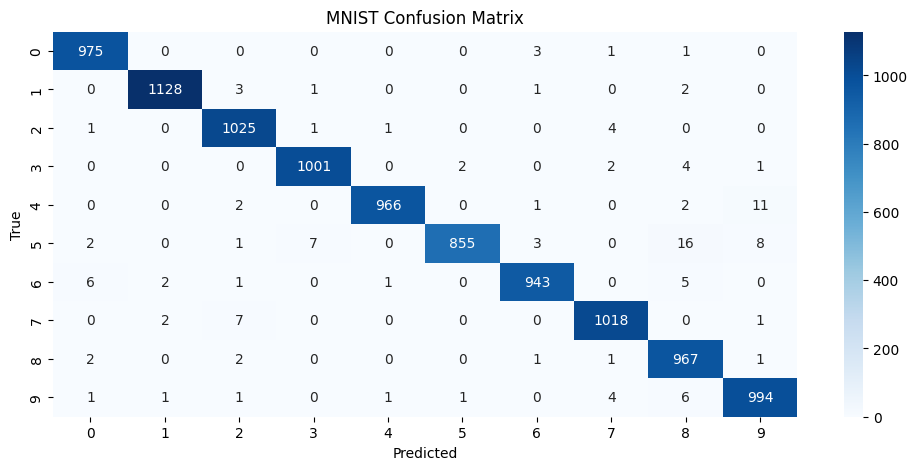

In [30]:
# Plotting the confusion Matrix
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device , non_blocking = True)
        y_batch = y_batch.to(device , non_blocking = True)

        y_pred = model(X_batch)
        predicted_classes = y_pred.argmax(dim=1)

        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)


plt.figure(figsize=(12,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MNIST Confusion Matrix")
plt.show()

# Threat Modelling
## Spoofing


## Data Poisoning

In [31]:
# Poisoning using the Fast Gradient Sign Method.

def fgsm(X_batch, y_batch, model, loss_fn, epsilon):
    X_batch = X_batch.clone().detach().to(device , non_blocking = True)
    y_batch = y_batch.clone().detach().to(device, non_blocking = True)
    fmodel = fb.PyTorchModel(model, bounds=(0, 1))
    attack = fb.attacks.FGSM()
    adv = attack(fmodel, X_batch, y_batch, epsilons=[epsilon])
    return adv[0][0]




In [32]:
def fgsm_manual(X_batch , y_batch , model , loss_fn , epsilon):
  X_batch = X_batch.clone().detach().to(device, non_blocking = True)
  X_batch.requires_grad = True
  y_batch = y_batch.clone().to(device, non_blocking = True)

  y_pred = model(X_batch)
  loss = loss_fn(y_pred , y_batch)

  model.zero_grad()
  loss.backward()

  sig = X_batch.grad.sign()

  X_batch = X_batch + epsilon * sig

  X_batch = torch.clamp(X_batch , 0 , 1)

  return X_batch

torch.Size([1, 28, 28])


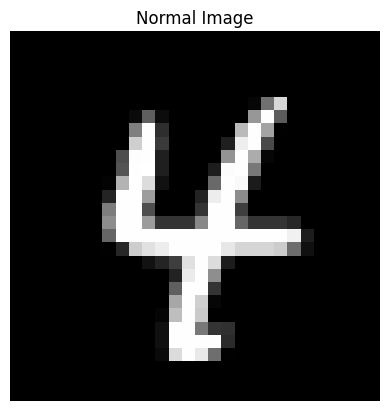

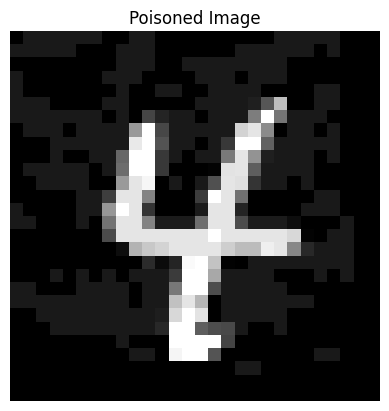

In [33]:
# Visualing Normal and Poisoned Images
X,y = next(iter(train_loader))
X_poisoned = fgsm(X , y , model , loss_fn , 0.1)


print(X_poisoned[0].shape)

normal_img = X[0].numpy().reshape(28,28)
poisoned_img = X_poisoned[0].cpu().detach().numpy().reshape(28,28)

plt.title('Normal Image')
plt.imshow(normal_img , cmap = 'gray')
plt.axis(False)
plt.show()
plt.title('Poisoned Image')
plt.imshow(poisoned_img , cmap = 'gray')
plt.axis(False)
plt.show()



In [34]:
# Testing the model with poisoned images.
correct = 0
total = 0

for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device, non_blocking = True)
            y_batch = y_batch.to(device, non_blocking = True)

            X_batch = fgsm(X_batch , y_batch , model , loss_fn , 0.1)
            y_pred = model(X_batch)


            predictions = y_pred.argmax(dim=1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
accuracy = correct / total
print(f"The Test Set Accuracy after FGSM Poisoining is : {accuracy * 100:.2f}")

The Test Set Accuracy after FGSM Poisoining is : 64.90


In [35]:
# Training the model with clean as well as the poisoned data.
model_2 = mnist_classifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters() , lr = 0.001)



for i in range(5):

  epoch_loss = 0.0

  print("Epoch ", i)


  for X_batch,y_batch in train_loader:

    X_batch = X_batch.to(device, non_blocking = True)
    y_batch = y_batch.to(device, non_blocking = True)

    model_2.eval()

    X_adv = fgsm(X_batch , y_batch , model_2 , loss_fn , 0.2)

    model_2.train()

    X = torch.cat((X_batch , X_adv) , dim = 0)
    y = torch.cat((y_batch , y_batch) , dim = 0)



    y_pred = model_2(X)

    optimizer.zero_grad()

    loss = loss_fn(y_pred, y)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()




  print(f"Loss : ", epoch_loss )
  epoch_loss = 0.0


Epoch  0
Loss :  568.97412969172
Epoch  1
Loss :  269.8974895849824
Epoch  2
Loss :  211.62001334130764
Epoch  3
Loss :  179.86250691115856
Epoch  4
Loss :  158.60001534223557


In [36]:
# Testing this robustness of the new model with a different epsilons (trained with epsilon = 0.1)

epsilons = [0.01 , 0.05 ,0.15 ,0.2]

for epsilon in epsilons:
  correct = 0
  total = 0

  for X_batch, y_batch in test_loader:
              model_2.eval()
              X_batch = X_batch.to(device, non_blocking = True)
              y_batch = y_batch.to(device, non_blocking = True)

              X_batch = fgsm(X_batch , y_batch , model_2 , loss_fn , epsilon)
              y_pred = model_2(X_batch)


              predictions = y_pred.argmax(dim=1)
              correct += (predictions == y_batch).sum().item()
              total += y_batch.size(0)
  accuracy = correct / total
  print(f"The Test Set Accuracy after FGSM (epsilon = {epsilon}) is : {accuracy * 100:.2f}")



The Test Set Accuracy after FGSM (epsilon = 0.01) is : 98.59
The Test Set Accuracy after FGSM (epsilon = 0.05) is : 97.34
The Test Set Accuracy after FGSM (epsilon = 0.15) is : 92.98
The Test Set Accuracy after FGSM (epsilon = 0.2) is : 90.11
